# 3D image classification from CT scans

**Author:** []()<br>
**Date created:** 2020/09/23<br>
**Last modified:** 2024/01/11<br>
**Description:** Train a 3D convolutional neural network to predict presence of pneumonia.

## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/abs/1808.01462)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](https://arxiv.org/abs/1607.05695)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

In [2]:
import os
import zipfile
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from torch.optim.lr_scheduler import ExponentialLR

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [3]:
import urllib.request

def download_and_extract(url, output_dir):
    zip_path = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as z_fp:
        z_fp.extractall(output_dir)

# Create directories
output_dir = os.path.join(os.getcwd(), "MosMedData")
os.makedirs(output_dir, exist_ok=True)

# Download and extract data
# download_and_extract("https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip", output_dir)
# download_and_extract("https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip", output_dir)


## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. CT scans store raw voxel
intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.
Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [4]:

import nibabel as nib

from scipy import ndimage

def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min, max = -1000, 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    desired_depth, desired_width, desired_height = 64, 128, 128
    current_depth, current_width, current_height = img.shape[-1], img.shape[0], img.shape[1]
    depth_factor, width_factor, height_factor = current_depth / desired_depth, current_width / desired_width, current_height / desired_height
    depth_factor, width_factor, height_factor = 1 / depth_factor, 1 / width_factor, 1 / height_factor
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume



Let's read the paths of the CT scans from the class directories.

In [ ]:
class CTScanDataset(Dataset):
    def __init__(self, scan_paths, labels, transform=None):
        self.scan_paths = scan_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.scan_paths)

    def __getitem__(self, idx):
        scan = self.scan_paths[idx]
        label = self.labels[idx]
        if self.transform:
            scan = self.transform(scan)
        return scan, label

# Prepare data
normal_scan_paths = [os.path.join(output_dir, "CT-0", x) for x in os.listdir(os.path.join(output_dir, "CT-0"))]
abnormal_scan_paths = [os.path.join(output_dir, "CT-23", x) for x in os.listdir(os.path.join(output_dir, "CT-23"))]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

# Process scans
abnormal_scans = [process_scan(path) for path in abnormal_scan_paths]
normal_scans = [process_scan(path) for path in normal_scan_paths]

abnormal_labels = [1 for _ in range(len(abnormal_scans))]
normal_labels = [0 for _ in range(len(normal_scans))]

# Split data
x_train = abnormal_scans[:70] + normal_scans[:70]
y_train = abnormal_labels[:70] + normal_labels[:70]
x_val = abnormal_scans[70:] + normal_scans[70:]
y_val = abnormal_labels[70:] + normal_labels[70:]

# Define transforms
train_transform = Compose([
    ToTensor(),
    Lambda(lambda x: x.unsqueeze(0))  # Add channel dimension
])

val_transform = Compose([
    ToTensor(),
    Lambda(lambda x: x.unsqueeze(0))  # Add channel dimension
])

# Create datasets
train_dataset = CTScanDataset(x_train, y_train, transform=train_transform)
val_dataset = CTScanDataset(x_val, y_val, transform=val_transform)


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [ ]:
# # Define data loaders.

batch_size = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [ ]:
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(kernel_size=2)
        self.bn1 = nn.BatchNorm3d(64)

        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2)
        self.bn2 = nn.BatchNorm3d(64)

        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool3d(kernel_size=2)
        self.bn3 = nn.BatchNorm3d(128)

        self.conv4 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool3d(kernel_size=2)
        self.bn4 = nn.BatchNorm3d(256)

        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(256, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.pool1(self.conv1(x))))
        x = F.relu(self.bn2(self.pool2(self.conv2(x))))
        x = F.relu(self.bn3(self.pool3(self.conv3(x))))
        x = F.relu(self.bn4(self.pool4(self.conv4(x))))
        x = self.global_pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = CNN3D().to(device)


## Train model

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.96)

num_epochs = 100

best_val_acc = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * inputs.size(0)
        train_correct += ((outputs > 0.5) == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += ((outputs > 0.5) == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "3d_image_classification.pth")
    
    
    # After training loop, append the performance metrics to history for visualization
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

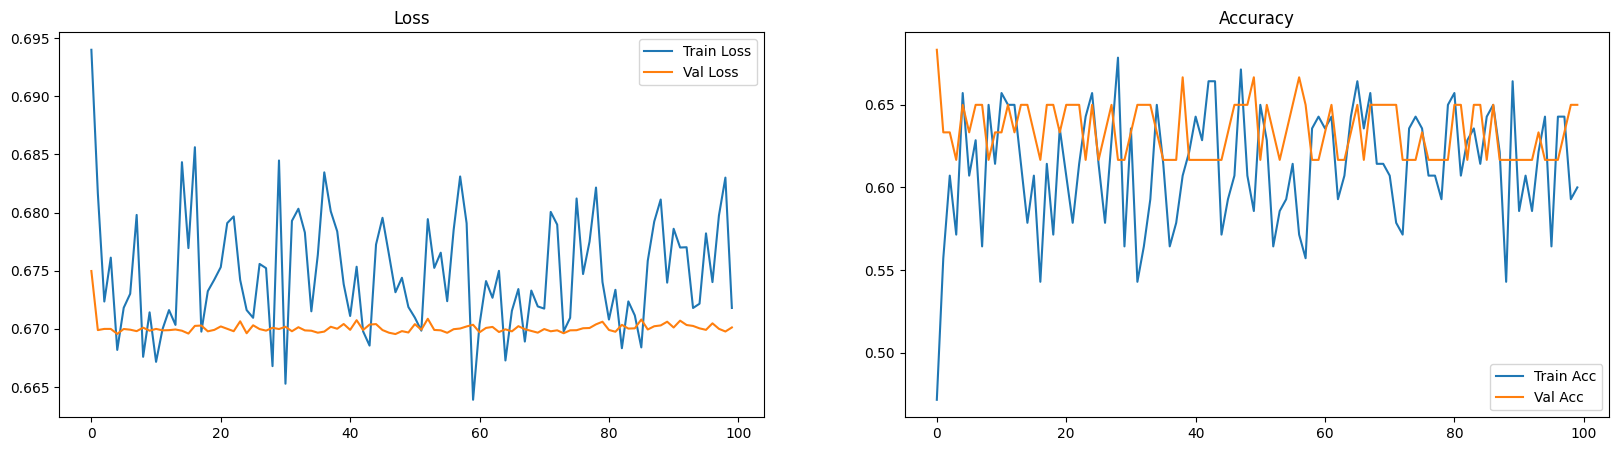

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Val Loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(history['train_acc'], label='Train Acc')
ax[1].plot(history['val_acc'], label='Val Acc')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()


## Make predictions on a single CT scan

In [12]:
model.load_state_dict(torch.load("3d_image_classification.pth"))

model.eval()
with torch.no_grad():
    sample = torch.tensor(x_val[0]).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
    prediction = model(sample).item()
    scores = [1 - prediction, prediction]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {score * 100:.2f} percent confident that CT scan is {name}")


This model is 46.16 percent confident that CT scan is normal
This model is 53.84 percent confident that CT scan is abnormal
